In [156]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import pandas as pd


from tensorflow import keras
from keras import layers
from keras.models import Sequential

In [157]:
import pathlib
data_dir = pathlib.Path("./train/")
data_dir_val = pathlib.Path("./test/")

In [158]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

batch_size = 34 # Divisors of number 1156: 1, 2, 4, 17, 34, 68, 289, 578, 1156
img_height = 180
img_width = 180

1156


In [159]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    seed=0
)

Found 1156 files belonging to 9 classes.


In [160]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_val,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  seed=0
  )

Found 502 files belonging to 9 classes.


In [161]:
class_names = train_ds.class_names
print(class_names)

# AUTOTUNE = tf.data.AUTOTUNE
# train_ds = train_ds.cache().shuffle(1111).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

['Ajwa', 'Galaxy', 'Medjool', 'Meneifi', 'NabtatAli', 'Rutab', 'Shaishe', 'Sokari', 'Sugaey']
0.005991098 0.9200073


In [162]:
num_classes = len(class_names)
epochs = 25
model = Sequential([
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(
                  from_logits=True),
              metrics=['accuracy'])

model.summary()


Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_33 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 178, 178, 16)      448       
                                                                 
 max_pooling2d_48 (MaxPoolin  (None, 89, 89, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_49 (Conv2D)          (None, 87, 87, 32)        4640      
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 43, 43, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 41, 41, 64)      

In [163]:
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  shuffle=False
)

Epoch 1/25
34/34 [==============================] - 16s 439ms/step - loss: 1.8718 - accuracy: 0.3166 - val_loss: 1.3196 - val_accuracy: 0.4781
Epoch 2/25
34/34 [==============================] - 15s 442ms/step - loss: 0.8627 - accuracy: 0.6990 - val_loss: 0.6615 - val_accuracy: 0.7450
Epoch 3/25
34/34 [==============================] - 15s 451ms/step - loss: 0.5663 - accuracy: 0.8088 - val_loss: 0.6996 - val_accuracy: 0.7709
Epoch 4/25
34/34 [==============================] - 16s 459ms/step - loss: 0.3976 - accuracy: 0.8573 - val_loss: 0.4801 - val_accuracy: 0.8088
Epoch 5/25
34/34 [==============================] - 18s 532ms/step - loss: 0.3088 - accuracy: 0.8953 - val_loss: 0.3870 - val_accuracy: 0.8566
Epoch 6/25
34/34 [==============================] - 19s 556ms/step - loss: 0.2888 - accuracy: 0.9109 - val_loss: 0.5036 - val_accuracy: 0.7908
Epoch 7/25
34/34 [==============================] - 17s 500ms/step - loss: 0.2841 - accuracy: 0.9109 - val_loss: 0.7515 - val_accuracy: 0.7371

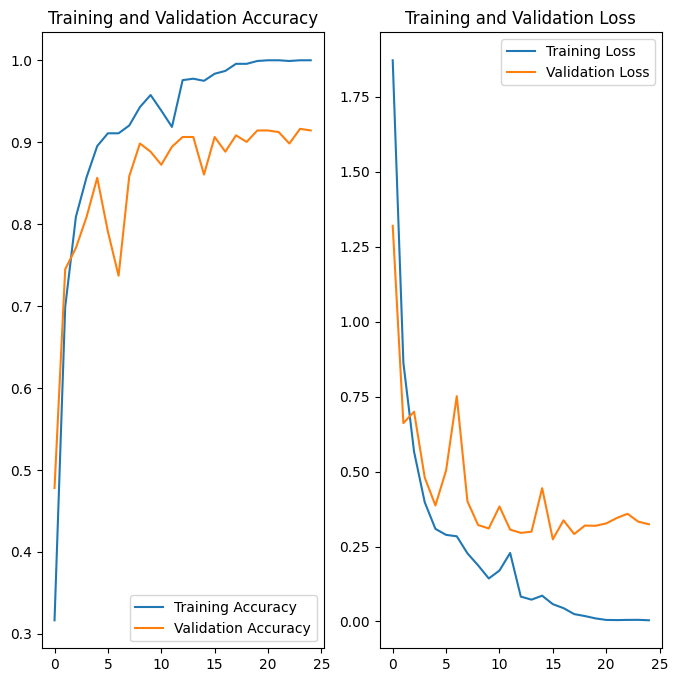

In [164]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [165]:
img = list(data_dir_val.glob('Medjool/*'))
img = PIL.Image.open(str(img[21])).resize((180, 180))
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 91ms/step
This image most likely belongs to Medjool with a 100.00 percent confidence.


In [166]:
predicted = []
true_labels = []
dirs = list(data_dir_val.glob('*'))

for d in range(len(dirs)):
    dir = dirs[d]
    predicted.append([])

    for image in dir.glob('*/'):
        image = PIL.Image.open(image).resize((180, 180))
        img_array = tf.keras.utils.img_to_array(image)
        img_array = tf.expand_dims(img_array, 0)

        predictions = model.predict(img_array)
        score = tf.nn.softmax(predictions[0])

        result = np.argmax(score)
        predicted[d].append(result)
        true_labels.append(d)

1/1 [==============================] - 0s 31ms/step


In [167]:
confusion_matrix = []
for l in range(len(predicted)):
    confusion_matrix.append([])
    for i in range(len(predicted)):
        confusion_matrix[l].append(predicted[l].count(i))

In [168]:
flat_predicted = [item for sublist in predicted for item in sublist]

print("Accuracy:", accuracy_score(true_labels, flat_predicted))

Accuracy: 0.9083665338645418


In [169]:
print(classification_report(true_labels, flat_predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        53
           1       0.96      0.88      0.92        57
           2       0.95      0.88      0.91        41
           3       0.81      0.86      0.83        70
           4       0.86      0.94      0.90        54
           5       0.91      0.91      0.91        44
           6       0.96      0.92      0.94        52
           7       0.93      0.93      0.93        80
           8       0.85      0.86      0.85        51

    accuracy                           0.91       502
   macro avg       0.91      0.91      0.91       502
weighted avg       0.91      0.91      0.91       502



<AxesSubplot: >

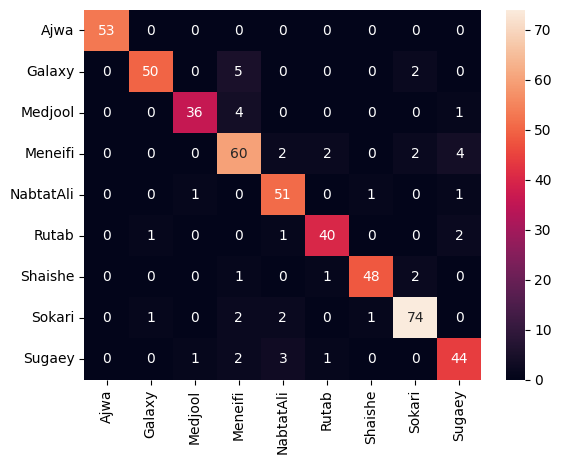

In [170]:
cm_df = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)
sns.heatmap(cm_df, annot=True)